# 2D Wave Propogation

We will numerically solve the wave equation in a 2D box.

The wave equation is given by:
$$
\frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u
$$
where $\nabla^2$ is the Laplacian operator, $c$ is the wave speed, and $u(x,y,t)$ is the wave function.

We will implement this using the finite differences method

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We need to discretise the equation. 

We will need a discrete approximation to the second derivative. This is naturally given by:
$$
    u_{tt_{ij}}^{(T)} = \frac{\frac{u_{ij}^{(T+1)} - u_{ij}^{(T)}}{t} - \frac{u_{ij}^{(T)} - u_{ij}^{(T-1)}}{t}}{t}
$$
$$
    = \frac{u_{ij}^{(T+1)} - 2u_{ij}^{(T)} + u_{ij}^{(T-1)}}{t^2}
$$

We will initially use a 3x3 matrix to discretise the Laplacian operator.

This matrix is given by:

$$
U_3 := \begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

i.e. the wave at a point moves to the four nearest neighbours. Therefore, we get

$$
    \nabla^2 u_{ij}^{(T)} \approx \frac{u_{i+1,j}^{(T)} + u_{i-1,j}^{(T)} + u_{i,j+1}^{(T)} + u_{i,j-1}^{(T)} - 4u_{ij}^{(T)}}{h^2}
$$

So we write the discretised wave equation as:
$$
    \frac{u_{ij}^{(T+1)} - 2u_{ij}^{(T)} + u_{ij}^{(T-1)}}{t^2} = c^2 \frac{u_{i+1,j}^{(T)} + u_{i-1,j}^{(T)} + u_{i,j+1}^{(T)} + u_{i,j-1}^{(T)} - 4u_{ij}^{(T)}}{h^2}
$$
Rearranging gives us:
$$
    u_{ij}^{(T+1)} = 2u_{ij}^{(T)} - u_{ij}^{(T-1)} + \frac{c^2 t^2}{h^2} \left( u_{i+1,j}^{(T)} + u_{i-1,j}^{(T)} + u_{i,j+1}^{(T)} + u_{i,j-1}^{(T)} - 4u_{ij}^{(T)} \right)
$$

We will test the simulation by placing a single pulse in the middle of the box and letting it propagate outwards.

In [383]:
# initialise

x_dim = 100
y_dim = 100
t_dim = 1000
h = 1
c = 0.1 

### Functions to initialise the state

In [384]:
def init_single_drop():
    """
    Initialise a single drop in the middle of the grid
    """
    x0 = int(x_dim/2)
    y0 = int(y_dim/2)
    space = np.zeros((x_dim,y_dim))
    space[x0,y0] = 1.0
    return space

In [385]:
def double_random_drop():
    """
    Initialise two drops at random locations in the grid
    """
    space = np.zeros((x_dim,y_dim))
    x0 = np.random.randint(0,x_dim-1)
    y0 = np.random.randint(0,y_dim-1)
    space[x0,y0] = 1.0
    x1 = np.random.randint(0,x_dim-1)
    y1 = np.random.randint(0,y_dim-1)
    space[x1,y1] = 1.0
    return space

In [386]:
space_single_drop = init_single_drop()

### Functions to run the simulation

In [387]:
def update(space, prev_space, absorb=False):
    """
    Update the space using the finite difference method
    """
    # create a new space to store the updated values
    new_space = np.zeros((x_dim,y_dim))
    
    # vectorised version of the update
    new_space = 2*space - prev_space + (c**2)*(np.roll(space, 1, axis=0) + np.roll(space, -1, axis=0) 
                                               + np.roll(space, 1, axis=1) + np.roll(space, -1, axis=1) 
                                               - 4*space)
    
    if absorb:
        # apply the absorbing boundary condition
        new_space[0,:] = space[1,:] + (c-1)/(c+1)*(new_space[1,:] - space[0,:])
        new_space[-1,:] = space[-2,:] + (c-1)/(c+1)*(new_space[-2,:] - space[-1,:])
        new_space[:,0] = space[:,1] + (c-1)/(c+1)*(new_space[:,1] - space[:,0])
        new_space[:,-1] = space[:,-2] + (c-1)/(c+1)*(new_space[:,-2] - space[:,-1])
        
    else:
        # Dirichlet boundary conditions
        new_space[0,:] = 0
        new_space[-1,:] = 0
        new_space[:,0] = 0
        new_space[:,-1] = 0
    
    return new_space

In [388]:
def run(initial_space, steps, absorb=False):
    """
    Run the simulation for a given number of steps
    """
    # create a list to store the results
    results = []
    
    # set the initial space and previous space
    prev_space = np.zeros((x_dim,y_dim))
    space = initial_space
    
    # loop over the steps and update the space
    for step in range(steps):
        results.append(space.copy())
        new_space = update(space, prev_space, absorb=absorb)
        prev_space = space.copy()
        space = new_space.copy()
    
    return np.array(results)

In [374]:
def run_rain(initial_space, steps, absorb=False):
    """
    Run the simulation for a given number of steps with random drops
    """
    # create a list to store the results
    results = []
    
    # set the initial space and previous space
    prev_space = np.zeros((x_dim,y_dim))
    space = initial_space
    
    # loop over the steps and update the space
    for step in range(steps):
        results.append(space.copy())
        if step % 50 == 0:
            x0 = np.random.randint(0,x_dim-1)
            y0 = np.random.randint(0,y_dim-1)
            space[x0,y0] = 1.0
        new_space = update(space, prev_space, absorb=absorb)
        prev_space = space.copy()
        space = new_space.copy()
    
    return np.array(results)

In [389]:
waves = run(double_random_drop(), t_dim, absorb=True)

In [378]:
waves = run_rain(double_random_drop(), t_dim, absorb=False)

### Check Initial State

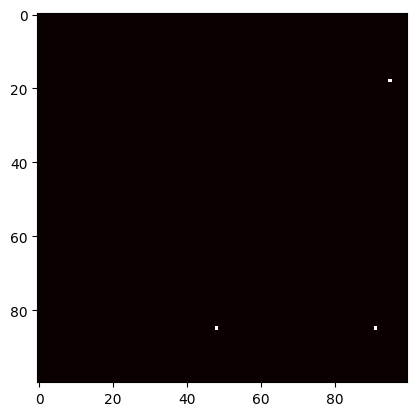

In [379]:
plt.imshow(waves[1], cmap='hot', interpolation='nearest')

### Check State Midway

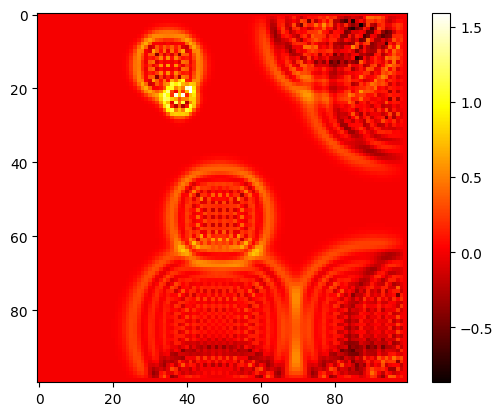

In [380]:
plt.imshow(waves[250], cmap='hot', interpolation='nearest')
plt.colorbar()

### Saving the state to a file

In [381]:
# write the simulation to a file
waves_df = pd.DataFrame(waves.reshape(t_dim, -1))
waves_df.to_csv('../simulations/output/waves.csv', index=False, header=False)